In [7]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import *

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [8]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [2]:
if os.name=='nt':
    !pip install wget
    import wget

### Load and Transform Data

In [9]:
BATCH_SIZE = 32
TARGET_SIZE = (244,244)

In [15]:
dataset = "D:/Proto/0AlejandroMausisa/Dataset/Train"
walk_through_dir(dataset);

There are 10 directories and 0 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train'.
There are 0 directories and 3 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Cassava Anthracnose Disease'.
There are 0 directories and 26 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Cassava Bacterial Blight'.
There are 0 directories and 32 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Cassava Brown Streak Disease'.
There are 0 directories and 7 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Cassava Green Mite'.
There are 0 directories and 22 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Cassava Root Rot Disease'.
There are 0 directories and 30 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Mosaic Disease'.
There are 0 directories and 27 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Normal Leaves'.
There are 0 directories and 24 images in 'D:/Proto/0AlejandroMausisa/Dataset/Train\Normal Stem'.
There are 0 directories and 25 images in 'D:/Proto/0AlejandroMausisa/D

In [16]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Preprocess and Augmentation

In [17]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [18]:
train_generator = ImageDataGenerator(
    rescale=1/.255,
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1/.255
)

In [19]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 289 validated image filenames belonging to 10 classes.
Found 72 validated image filenames belonging to 10 classes.
Found 91 validated image filenames belonging to 10 classes.


In [20]:
# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
])

# Training the Model

In [22]:
# Create checkpoint callback
checkpoint_path = "1cassava_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)

In [23]:
# Define the input layer with the shape of the original images
inputs = Input(shape=(244, 244, 3))

# Add a resizing layer to match the input shape expected by the pretrained model
x = Resizing(224, 224)(inputs)

# Apply augmentations (assuming augment is a previously defined function or layer)
# Ensure augment is correctly defined and does not return None
x = augment(x)  # If augment can return None, add a check or a default return value

# Load your pretrained model (e.g., EfficientNetB0) without the top classification layer
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Connect the resized and augmented input to the pretrained model
x = pretrained_model(x)
x = GlobalAveragePooling2D()(x)  # Pooling to reduce dimensions

# Add your custom layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(10, activation='softmax')(x)  # Adjust to 10 classes

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Assuming train_images and val_images are properly defined datasets
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images) // 32,
    validation_data=val_images,
    validation_steps=len(val_images) // 32,
    epochs=400,
    callbacks=[
        #early_stopping,
        create_tensorboard_callback("training_logs", "cassava_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)


Saving TensorBoard log files to: training_logs/cassava_classification/20240924-213225
Epoch 1/400


D:\proto\0AlejandroMausisa\tfod\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.0773 - loss: 2.3643 - val_accuracy: 0.0972 - val_loss: 2.3122 - learning_rate: 0.0010
Epoch 2/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1693 - loss: 2.2001 - val_accuracy: 0.1528 - val_loss: 2.2635 - learning_rate: 0.0010
Epoch 3/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.1671 - loss: 2.2294 - val_accuracy: 0.0972 - val_loss: 2.2380 - learning_rate: 0.0010
Epoch 4/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.2492 - loss: 2.0105 - val_accuracy: 0.0972 - val_loss: 2.2609 - learning_rate: 0.0010
Epoch 5/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2582 - loss: 2.0194 - val_accuracy: 0.1528 - val_loss: 2.2013 - learning_rate: 0.0010
Epoch 6/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3126 - loss: 1.8575 - val_accuracy: 0.1528 - val_loss: 2.1765 - learning_rate: 0.0010
Epoch 7/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3271 - loss: 1.8556 - val_accuracy: 0.097

In [24]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.01329
Test Accuracy: 89.01%


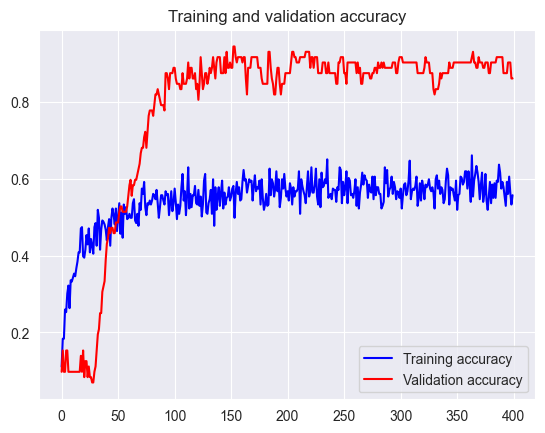

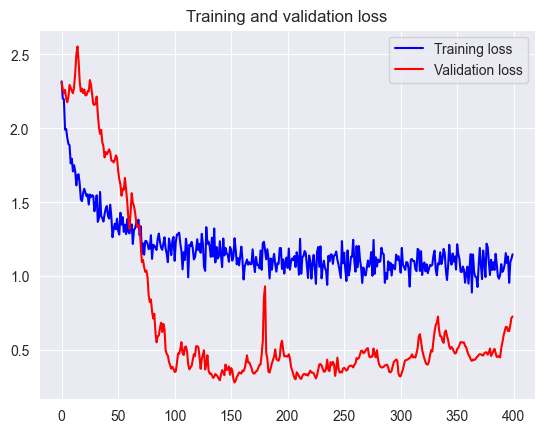

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step 
The first 5 predictions: ['Cassava Anthracnose Disease', 'Normal Leaves', 'Cassava Brown Streak Disease', 'Cassava Brown Streak Disease', 'Cassava Bacterial Blight']


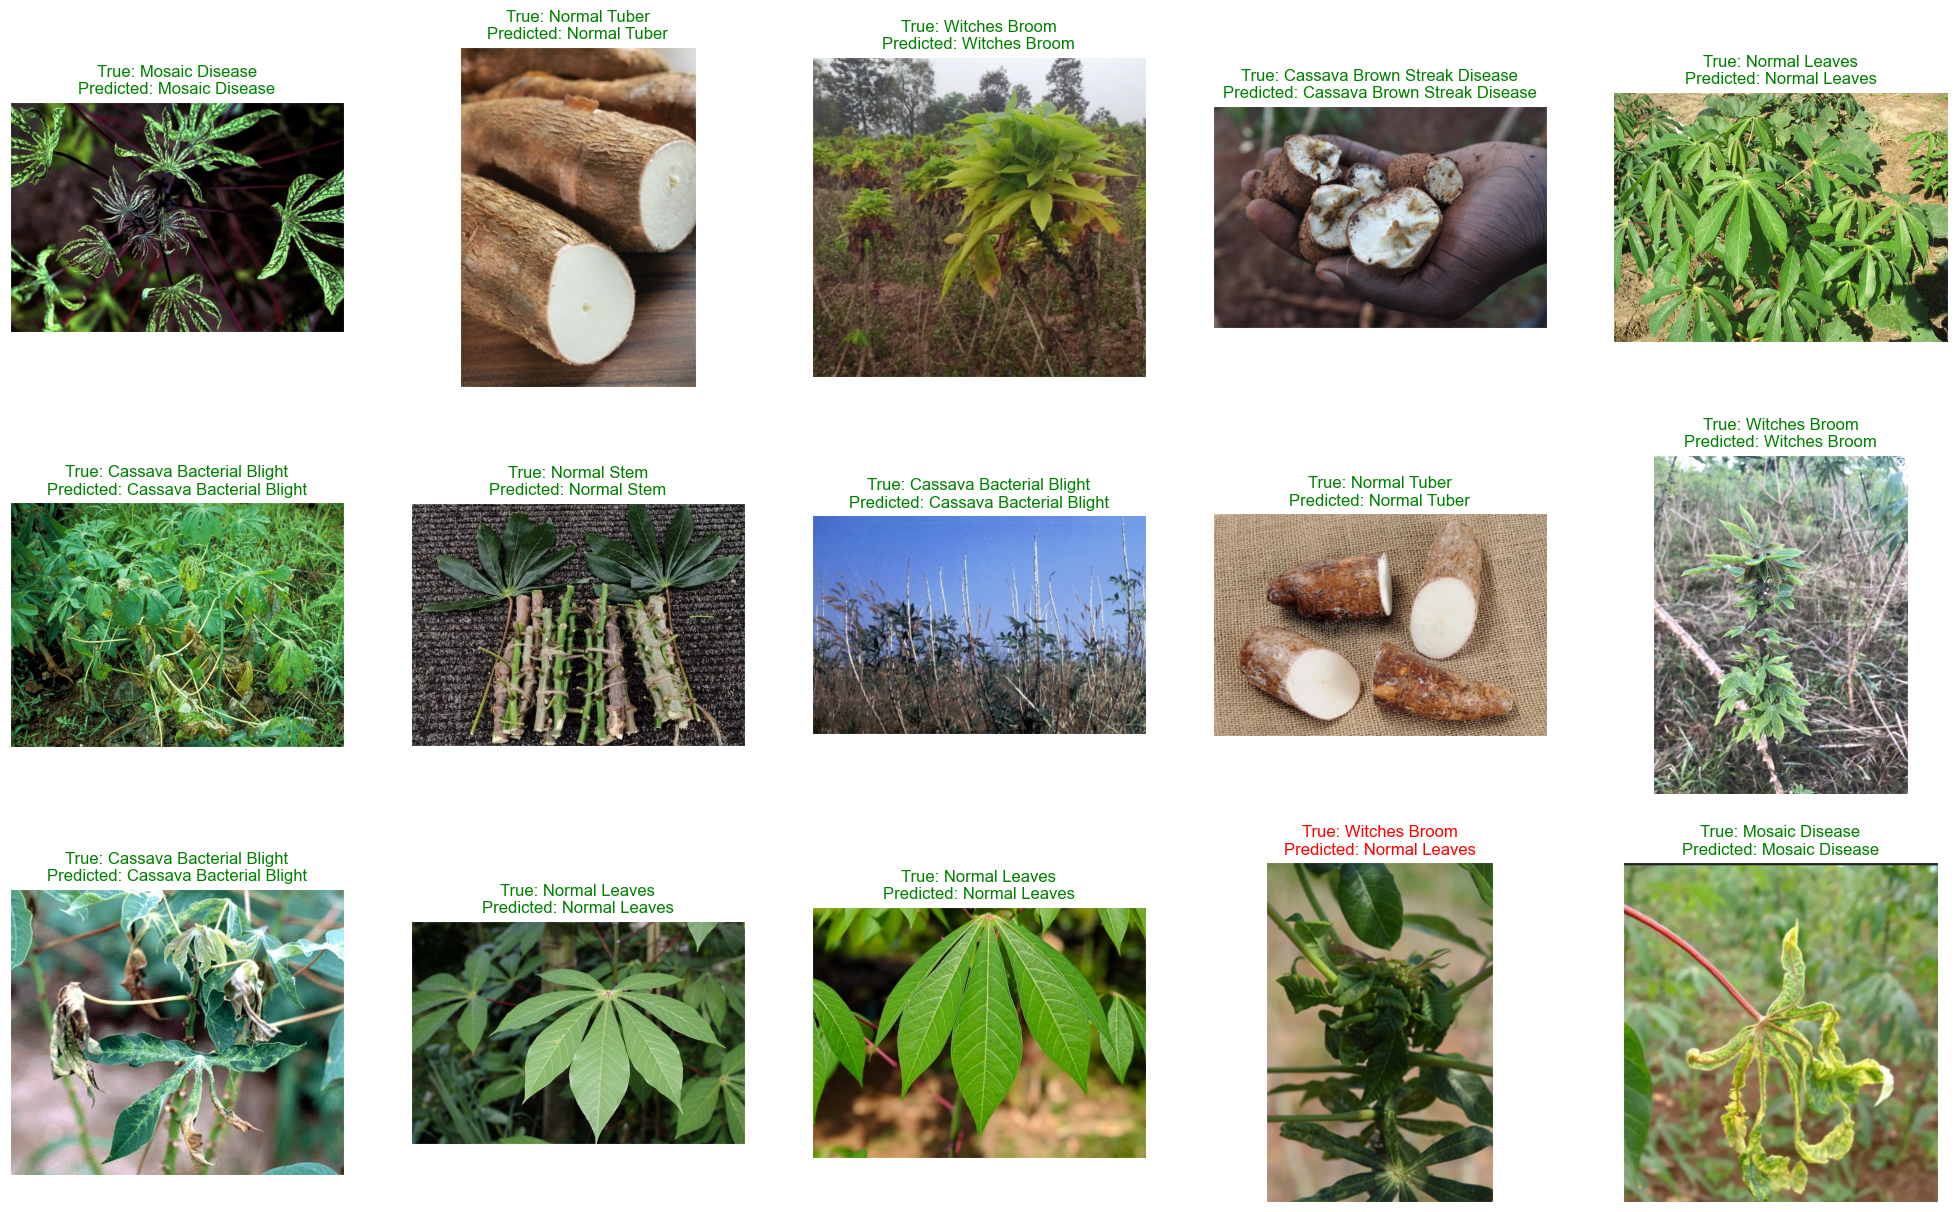

<Figure size 640x480 with 0 Axes>

In [27]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [28]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                              precision    recall  f1-score   support

 Cassava Anthracnose Disease       1.00      0.33      0.50         3
    Cassava Bacterial Blight       0.89      0.89      0.89         9
Cassava Brown Streak Disease       1.00      1.00      1.00         9
          Cassava Green Mite       1.00      0.67      0.80         3
    Cassava Root Rot Disease       1.00      0.71      0.83         7
              Mosaic Disease       0.91      0.83      0.87        12
               Normal Leaves       0.75      1.00      0.86        12
                 Normal Stem       1.00      1.00      1.00         9
                Normal Tuber       0.80      1.00      0.89         8
               Witches Broom       0.89      0.89      0.89        19

                    accuracy                           0.89        91
                   macro avg       0.92      0.83      0.85        91
                weighted avg       0.90      0.89      0.89        91

